# 04. Clustering Models

## Objective
This notebook focuses on applying and comparing various clustering algorithms to segment customers based on the dimensionality-reduced data (UMAP 10D) prepared in the previous notebook.

We will implement:
- **K-Means Clustering**
- **Gaussian Mixture Models (GMM)**
- **DBSCAN**
- **HDBSCAN**

We will evaluate these models using quantitative metrics (Silhouette Score, etc.) and select the best one for further profiling in the next notebook.

**Note:** No cluster profiling or business interpretation is performed in this notebook.

## 1. Setup and Data Loading

In [49]:
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, make_scorer, calinski_harabasz_score, davies_bouldin_score

# Plot settings
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams['figure.dpi'] = 100

# Paths
DATA_DIR = Path('../data/processed')
MODELS_DIR = Path('../models')
IMAGES_DIR = Path('../images')

def save_fig(name):
    plt.savefig(IMAGES_DIR / f"{name}.png", dpi=300, bbox_inches='tight')

In [25]:
# Load Data
umap_10d_path = DATA_DIR / 'umap_10d.csv'
umap_2d_path = DATA_DIR / 'umap_2d.csv'

df_umap_10d = pd.read_csv(umap_10d_path)
df_umap_2d = pd.read_csv(umap_2d_path)

# Extract CustomerID
customer_ids = df_umap_10d['CustomerID']

# Prepare X (UMAP 10D only)
X = df_umap_10d.drop(columns=['CustomerID']).values

print(f"Data loaded. Shape of X: {X.shape}")

Data loaded. Shape of X: (5878, 10)


## 2. Clustering Algorithms

### 2.1 K-Means Clustering

k=3, Silhouette=0.4273
k=4, Silhouette=0.4647
k=5, Silhouette=0.4498
k=6, Silhouette=0.4631
k=7, Silhouette=0.4623
k=8, Silhouette=0.4428
k=9, Silhouette=0.4478
k=10, Silhouette=0.4511


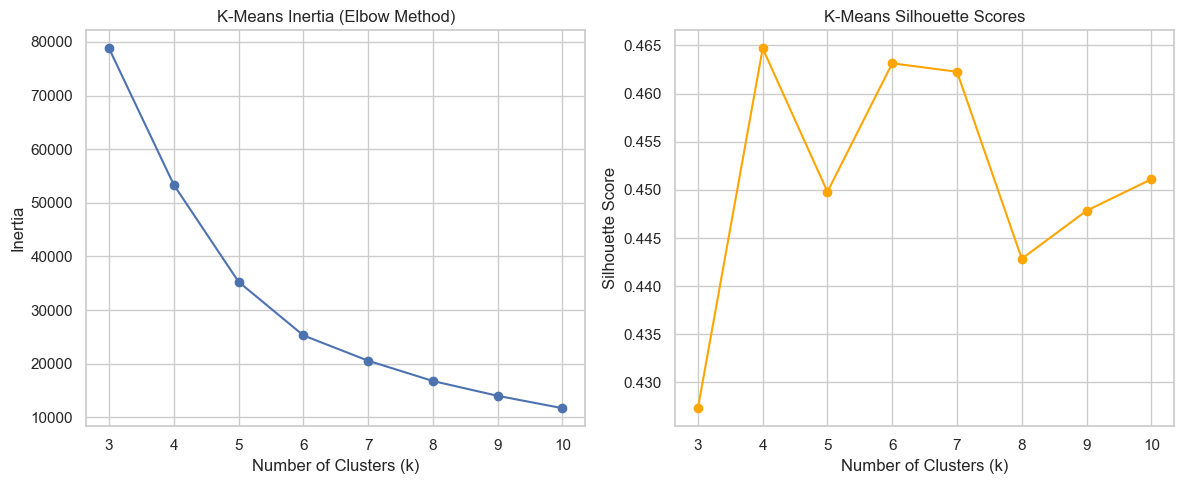

In [26]:
inertia = []
silhouette_scores_kmeans = []
k_range = range(3, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores_kmeans.append(score)
    print(f"k={k}, Silhouette={score:.4f}")

# Plot Inertia (Elbow Method)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('K-Means Inertia (Elbow Method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_kmeans, marker='o', color='orange')
plt.title('K-Means Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
save_fig('kmeans_elbow_and_silhouette')
plt.show()

The elbow curve and silhouette scores provide complementary signals about the optimal number of clusters.

#### **1. Elbow Method (Inertia)**
- Inertia drops sharply from **k = 3 to k = 5**, then flattens.
- If we relied only on this curve, **k = 5 or k = 6** might seem reasonable.

#### **2. Silhouette Scores**
- The highest silhouette score occurs at **k = 4**, indicating well-separated, cohesive clusters.
- **k = 5** shows a strong drop, suggesting unstable or overlapping clusters.
- **k = 6 and k = 7** produce silhouette scores almost as high as k = 4, meaning the structure is still meaningful.

#### **3. Two Strong Candidates Emerge**

###### **k = 4 (Most robust separation)**
- Highest silhouette score.
- Simpler segmentation for business interpretation.
- Very good separation between clusters.

###### **k = 6 (More granular segmentation)**
- Silhouette score nearly identical to k = 4.
- Inertia is **much lower** → clusters are tighter and more compact.
- Useful when finer segmentation is desired.

---

Both **k = 4** and **k = 6** are valid solutions.  
The clustering notebook will visualize and compare both options to support the final decision.

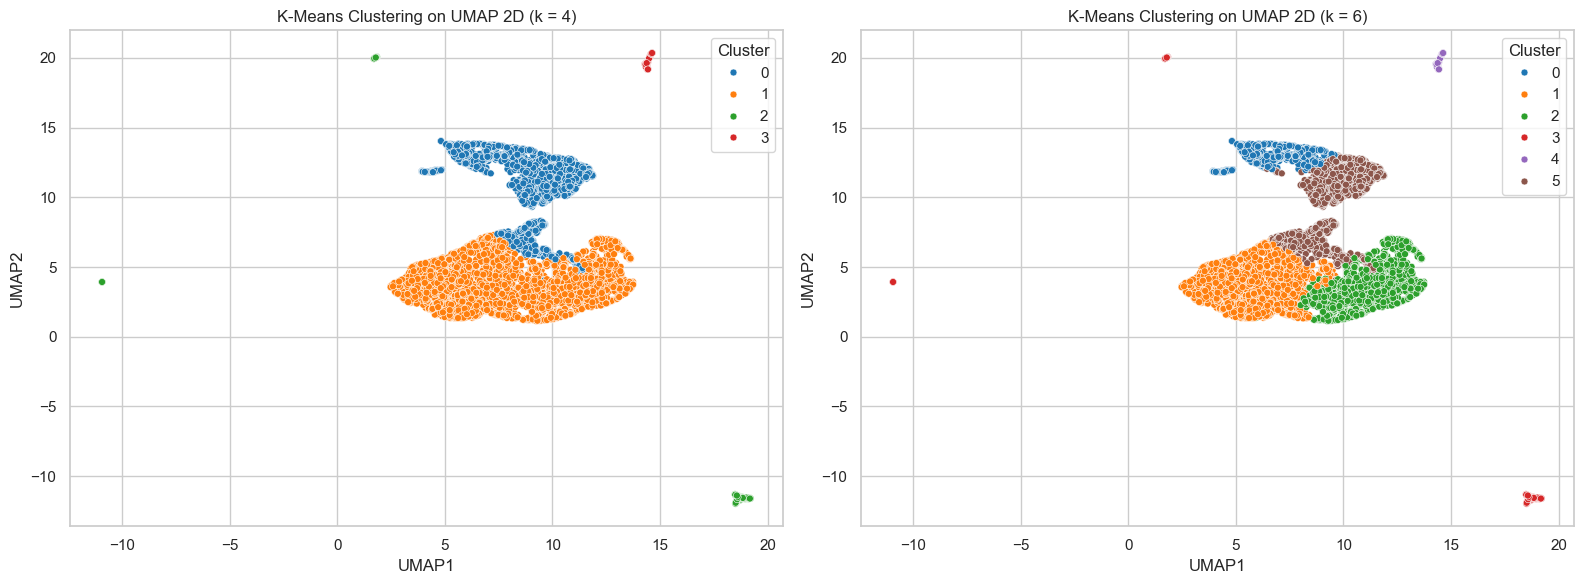

In [27]:
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_6 = KMeans(n_clusters=6, random_state=42, n_init=10)

labels_4 = kmeans_4.fit_predict(X)
labels_6 = kmeans_6.fit_predict(X)

# Add labels to UMAP 2D df
df_umap_2d['Cluster_k4'] = labels_4
df_umap_2d['Cluster_k6'] = labels_6

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# k = 4 
sns.scatterplot(
    data=df_umap_2d,
    x='UMAP1', y='UMAP2',
    hue='Cluster_k4',
    palette='tab10',
    s=25,
    ax=axes[0]
)
axes[0].set_title("K-Means Clustering on UMAP 2D (k = 4)")
axes[0].set_xlabel("UMAP1")
axes[0].set_ylabel("UMAP2")
axes[0].legend(title="Cluster")

# k = 6
sns.scatterplot(
    data=df_umap_2d,
    x='UMAP1', y='UMAP2',
    hue='Cluster_k6',
    palette='tab10',
    s=25,
    ax=axes[1]
)
axes[1].set_title("K-Means Clustering on UMAP 2D (k = 6)")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].legend(title="Cluster")

plt.tight_layout()
save_fig("kmeans_k4_k6")
plt.show()

> The UMAP visualizations reveal how the data behaves when segmented into 4 and 6 clusters. Both configurations are valid, but they offer different levels of granularity.


##### **k = 4 - Clear, High-Level Segmentation**

- Two **large, well-separated clusters** appear, representing the main customer groups.
- A few **small isolated clusters** correspond to outliers or highly atypical customers.
- The structure is **clean and easy to interpret**, with minimal overlap.

> **What it means:**  
> k = 4 captures the *macro-structure* of the dataset. Clusters are stable, well-separated, and suitable for business-oriented segmentation.


##### **k = 6 - More Detailed Sub-Segmentation**

- The two large clusters from k = 4 are **split into sub-groups**, revealing finer behavioral patterns.
- Outliers are better integrated into meaningful clusters.
- The overall shape remains consistent, showing that the segmentation is still structurally sound.

> **What it means:**  
> k = 6 exposes **meaningful sub-clusters** inside the major groups. This gives deeper insight but increases complexity.


### **Which one is better?**

Both options make sense:

##### **k = 4 (Simplest & Most Robust)**
- Highest silhouette score  
- Best global separation  
- Ideal for practical segmentation (marketing, scoring, dashboards)

##### **k = 6 (More Granular & Insightful)**
- Nearly identical silhouette score  
- Much lower inertia → tighter, more compact clusters  
- Useful when fine-grained understanding is needed

---

### **Conclusion**
**k = 4** provides a clean, high-level segmentation.  
**k = 6** offers richer detail while preserving good cluster quality.

Both configurations are valid, the choice depends on the desired level of granularity for the analysis.

---

### 2.2 Gaussian Mixture Models (GMM)

n=3, Silhouette=0.4198, BIC=-59696
n=4, Silhouette=0.4099, BIC=-131545
n=5, Silhouette=0.4433, BIC=-152575
n=6, Silhouette=0.4544, BIC=-177746
n=7, Silhouette=0.4453, BIC=-194515
n=8, Silhouette=0.4143, BIC=-197494
n=9, Silhouette=0.4318, BIC=-212899
n=10, Silhouette=0.4347, BIC=-218459


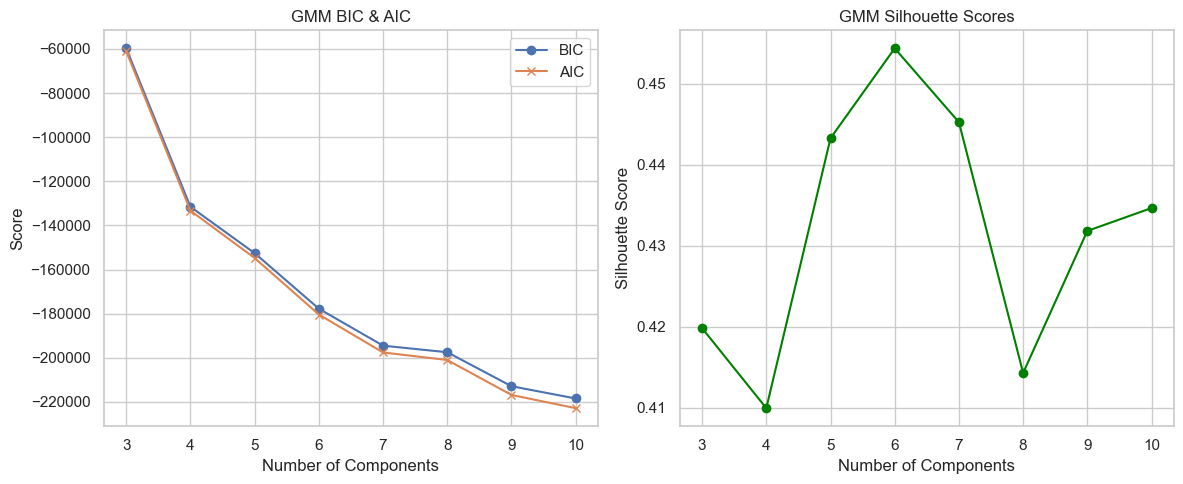

Best components for GMM: 6


In [28]:
bic_scores = []
aic_scores = []
silhouette_scores_gmm = []
components_range = range(3, 11)

for n in components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    
    bic_scores.append(gmm.bic(X))
    aic_scores.append(gmm.aic(X))
    score = silhouette_score(X, labels)
    silhouette_scores_gmm.append(score)
    print(f"n={n}, Silhouette={score:.4f}, BIC={gmm.bic(X):.0f}")

# Plot BIC and AIC
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(components_range, bic_scores, label='BIC', marker='o')
plt.plot(components_range, aic_scores, label='AIC', marker='x')
plt.title('GMM BIC & AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(components_range, silhouette_scores_gmm, marker='o', color='green')
plt.title('GMM Silhouette Scores')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.tight_layout()
save_fig('gmm_silhouette_scores')
plt.show()

# Select best GMM (using Silhouette for consistency, but checking BIC)
best_n_gmm = components_range[np.argmax(silhouette_scores_gmm)]
print(f"Best components for GMM: {best_n_gmm}")

gmm_final = GaussianMixture(n_components=best_n_gmm, random_state=42)
gmm_labels = gmm_final.fit_predict(X)

The GMM evaluation shows us this points:

**1. BIC & AIC**  
Both metrics decrease continuously from 3 to 10 components.  
Since they improve monotonically, they don't provide a meaningful cutoff and cannot be used to pick the optimal number of clusters here.

**2. Silhouette Score**  
The silhouette curve clearly peaks at **n = 6**, indicating the best balance between cluster cohesion and separation.  
Values around n = 4 and n = 7 are acceptable, but n = 6 is the strongest.

**3. Final Choice**  
Because silhouette is the most reliable clustering quality metric here and because the result is consistent with the K-Means analysis,  
I adopt **GMM with 6 components** as the final configuration.

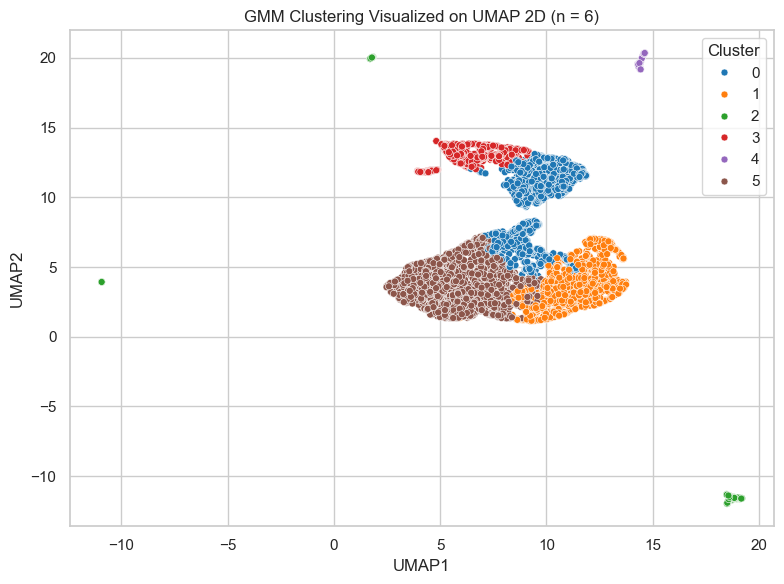

In [29]:
gmm_6 = GaussianMixture(n_components=6, random_state=42)
gmm_labels_6 = gmm_6.fit_predict(X)

df_umap_2d['GMM_6'] = gmm_labels_6

# Plot GMM Results on UMAP 2D 
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_umap_2d,
    x='UMAP1', y='UMAP2',
    hue='GMM_6',
    palette='tab10',
    s=25
)
plt.title("GMM Clustering Visualized on UMAP 2D (n = 6)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title='Cluster')
plt.tight_layout()
save_fig("gmm_k6")
plt.show()

The GMM model with **6 components** produces a segmentation that is both coherent and well-structured in the UMAP 2D space. Several important observations emerge:

- The **overall cluster layout strongly resembles the K-Means result with k = 6**, confirming that the data naturally contains six meaningful subgroups.  
  GMM refines this structure but does not contradict it, which strengthens confidence in the segmentation.

- GMM produces **smoother, more flexible boundaries** compared to K-Means. This is expected, since GMM models clusters as ellipses with soft assignment instead of rigid Voronoi partitions.  
  As a result, dense regions are split in a more natural way, especially in areas where K-Means might impose artificial straight borders.

- The model identifies **small, distinct groups** (top right, bottom right, far left), which correspond to unusual or niche customer behaviors.  
  Their isolation is consistent across both K-Means and GMM, showing that these customers are genuinely different from the main population.

- The large central regions show **well-separated subclusters**, suggesting that customer behaviors are not homogeneous inside these dense zones.

Overall, the visual patterns confirm that **6-component GMM reveals nearly the same structure as K-Means (k = 6)** but with more nuanced and probabilistic boundaries.  
This consistency across two different algorithms indicates that **six clusters is a stable and meaningful segmentation** for the dataset.

### 2.3 DBSCAN

In [ ]:
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 20]

best_dbscan_score = -1
best_dbscan_params = None
best_dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # I check if we have more than 1 cluster (excluding noise -1)
        unique_labels = set(labels)
        if len(unique_labels) > 1:
            score = silhouette_score(X, labels)
            n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
            noise_ratio = np.sum(labels == -1) / len(labels)
            
            print(f"eps={eps}, min_samples={min_samples} -> Clusters={n_clusters}, Noise={noise_ratio:.2%}, Silhouette={score:.4f}")
            
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = (eps, min_samples)
                best_dbscan_labels = labels
        else:
            print(f"eps={eps}, min_samples={min_samples} -> Only 1 cluster or noise found.")

print(f"Best DBSCAN Params: {best_dbscan_params} with Silhouette: {best_dbscan_score:.4f}")

eps=0.3, min_samples=5 -> Clusters=11, Noise=1.34%, Silhouette=-0.4473
eps=0.3, min_samples=10 -> Clusters=26, Noise=5.27%, Silhouette=-0.1334
eps=0.3, min_samples=20 -> Clusters=54, Noise=27.27%, Silhouette=0.0932
eps=0.5, min_samples=5 -> Clusters=6, Noise=0.03%, Silhouette=-0.1379
eps=0.5, min_samples=10 -> Clusters=6, Noise=0.03%, Silhouette=-0.1379
eps=0.5, min_samples=20 -> Clusters=6, Noise=0.37%, Silhouette=0.1631
eps=0.7, min_samples=5 -> Clusters=6, Noise=0.00%, Silhouette=0.3277
eps=0.7, min_samples=10 -> Clusters=6, Noise=0.00%, Silhouette=0.3277
eps=0.7, min_samples=20 -> Clusters=5, Noise=0.19%, Silhouette=0.3277
Best DBSCAN Params: (0.7, 5) with Silhouette: 0.3277


Plot of DBSCAN with eps=0.7, min_samples=5


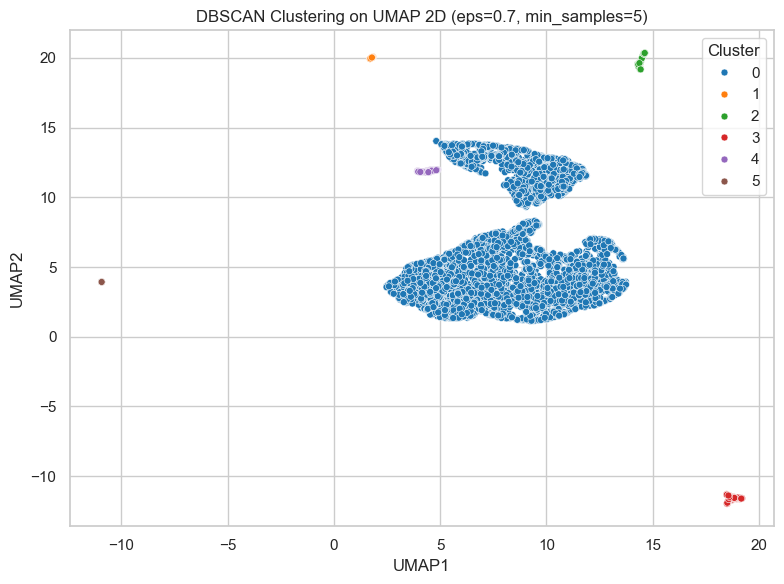

In [40]:
# Best DBSCAN model Plot
best_eps, best_min_samples = best_dbscan_params
print(f"Plot of DBSCAN with eps={best_eps}, min_samples={best_min_samples}")

dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_final.fit_predict(X)

df_umap_2d['DBSCAN'] = dbscan_labels

# Prepare color palette (DBSCAN may include -1 for noise)
unique_labels = sorted(set(dbscan_labels))
n_clusters = len([l for l in unique_labels if l != -1])

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_umap_2d,
    x='UMAP1',
    y='UMAP2',
    hue='DBSCAN',
    palette='tab10',
    s=25
)
plt.title(f"DBSCAN Clustering on UMAP 2D (eps={best_eps}, min_samples={best_min_samples})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.tight_layout()
save_fig("dbscan_best")
plt.show()

The DBSCAN exploration shows that density-based clustering doesn't perform well on this dataset.  
Most parameter combinations produce either:

- **too many micro-clusters** (up to 54 groups), or
- **very low silhouette scores** (below 0.33).

Even the best configuration  
**(eps = 0.7, min_samples = 5)**  
reaches only a **0.327 silhouette score**, far below the performance of **K-Means and GMM (~0.45)**.

This indicates that the dataset does **not** exhibit strong density-separated structures, and DBSCAN struggles to form stable, meaningful clusters.

**Conclusion:**  
DBSCAN is **not suitable** for this segmentation task and will only be kept for comparison purposes.

---

### 2.4 HDBSCAN

In [45]:
import hdbscan

min_cluster_sizes = [5, 10, 15, 20, 25]

best_hdbscan_score = -1
best_hdbscan_mcs = None
best_hdbscan_labels = None

for mcs in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, gen_min_span_tree=True)
    labels = clusterer.fit_predict(X)
    
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        score = silhouette_score(X, labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)
        
        print(f"min_cluster_size={mcs} -> Clusters={n_clusters}, Noise={noise_ratio:.2%}, Silhouette={score:.4f}")
        
        if score > best_hdbscan_score:
            best_hdbscan_score = score
            best_hdbscan_mcs = mcs
            best_hdbscan_labels = labels
    else:
        print(f"min_cluster_size={mcs} -> Only 1 cluster or noise found.")

print(f"Best HDBSCAN min_cluster_size: {best_hdbscan_mcs} with Silhouette: {best_hdbscan_score:.4f}")

C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=5 -> Clusters=207, Noise=36.83%, Silhouette=-0.0178


C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=10 -> Clusters=9, Noise=0.12%, Silhouette=0.3214


C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=15 -> Clusters=7, Noise=0.12%, Silhouette=0.3207


C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=20 -> Clusters=6, Noise=0.03%, Silhouette=0.3195


C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=25 -> Clusters=5, Noise=0.00%, Silhouette=0.3257
Best HDBSCAN min_cluster_size: 25 with Silhouette: 0.3257


C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\lereu\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


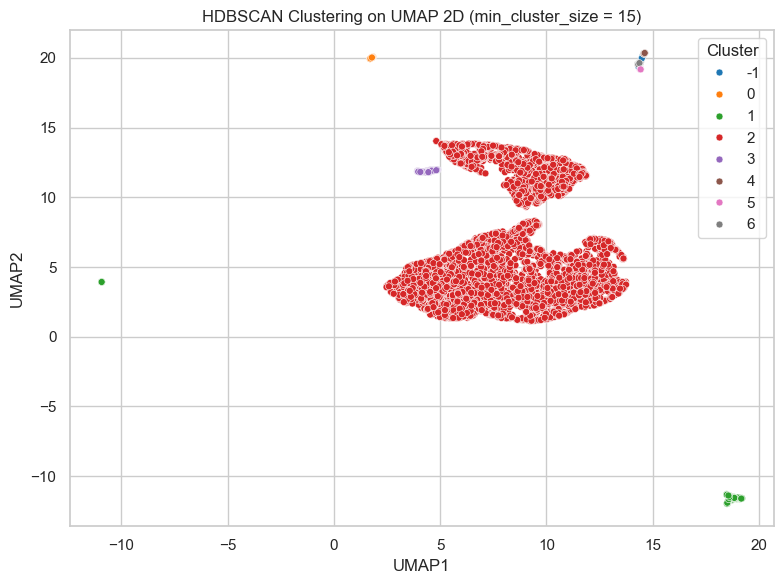

In [47]:
# Best HDBSCAN model Plot
best_mcs = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=best_mcs, gen_min_span_tree=True)
hdb_labels = clusterer.fit_predict(X)

# Add labels to UMAP 2D DataFrame
df_umap_2d['HDBSCAN'] = hdb_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_umap_2d,
    x='UMAP1', y='UMAP2',
    hue='HDBSCAN',
    palette='tab10',
    s=25
)
plt.title(f"HDBSCAN Clustering on UMAP 2D (min_cluster_size = {best_mcs})")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title='Cluster')
plt.tight_layout()
save_fig("hdbscan_best")
plt.show()


HDBSCAN, like DBSCAN, does not perform well on this dataset.  
Even its best configuration (min_cluster_size = 15,25) produces:

- Mostly one dominant cluster,
- A few tiny unstable clusters,
- A silhouette score around 0.32 (far below K-Means and GMM ≈ 0.45),
- Almost no meaningful structure in the UMAP 2D projection.

This confirms that the dataset does not naturally form density-based clusters.  
HDBSCAN is therefore **not suitable** for this segmentation task and will only be retained for comparison.

### 3. Baseline Model Comparison & Selection

In [ ]:
# function to get stats
def get_stats(labels, model_name):
    if labels is None:
        return {"Model": model_name, "Clusters": 0, "Silhouette": -1, "Noise Ratio": "N/A"}
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels) if -1 in labels else 0.0
    if n_clusters > 1:
        sil = silhouette_score(X, labels)
    else:
        sil = -1
    return {"Model": model_name, "Clusters": n_clusters, "Silhouette": sil, "Noise Ratio": f"{noise_ratio:.2%}"}

stats = []
stats.append(get_stats(kmeans_labels, "K-Means"))
stats.append(get_stats(gmm_labels, "GMM"))
stats.append(get_stats(best_dbscan_labels, "DBSCAN"))
stats.append(get_stats(best_hdbscan_labels, "HDBSCAN"))

df_stats = pd.DataFrame(stats)
display(df_stats)

,Model,Clusters,Silhouette,Noise Ratio
0,K-Means,4,0.464688,0.00%
1,GMM,6,0.454386,0.00%
2,DBSCAN,6,0.327684,0.00%
3,HDBSCAN,5,0.325692,0.00%


Across all baseline algorithms, **K-Means delivers the best overall clustering performance**:

- **K-Means** achieves the highest silhouette score (~0.465) and produces clear, stable groups.
- **GMM** performs similarly but does not surpass K-Means.
- **DBSCAN** and **HDBSCAN** fail to identify meaningful structure, confirming that density-based methods are not suitable for this dataset.

**K-Means is therefore selected as the best baseline model.**

---

#### **Next Step**

I will now **tune K-Means** using loops (Cross-Validation is unpractical here) to optimize its hyperparameters and push the clustering quality as far as possible before final profiling.

In [53]:
best_score = -1
best_params = None

for k in [4, 5, 6, 7, 8, 9]:
    for init in ["k-means++", "random"]:
        for n_init in [10, 20, 50]:
            for max_iter in [300, 500]:

                model = KMeans(
                    n_clusters=k,
                    init=init,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=42
                )

                labels = model.fit_predict(X)
                score = silhouette_score(X, labels)

                if score > best_score:
                    best_score = score
                    best_params = (k, init, n_init, max_iter)

print("Best score:", best_score)
print("Best params:", best_params)

Best score: 0.4646881271705133
Best params: (4, 'k-means++', 10, 300)


In [56]:
# Train best model

best_k, best_init, best_ninit, best_maxiter = best_params

best_kmeans = KMeans(
    n_clusters=best_k,
    init=best_init,
    n_init=best_ninit,
    max_iter=best_maxiter,
    random_state=42
)

best_labels = best_kmeans.fit_predict(X)

print("Best n_clusters:", best_kmeans.n_clusters)

df_umap_2d["Best_KMeans"] = best_labels

Best n_clusters: 4


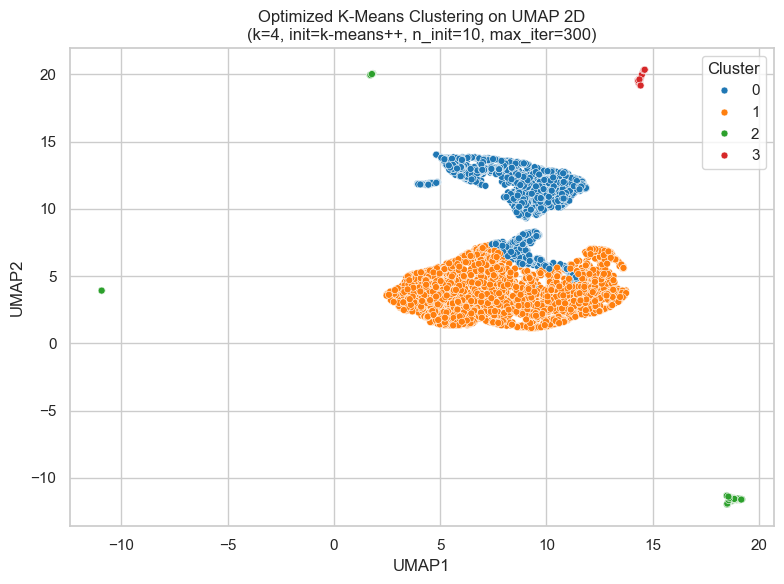

In [55]:
# Plot the best K-Means on UMAP2D

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_umap_2d,
    x="UMAP1", y="UMAP2",
    hue="Best_KMeans",
    palette="tab10",
    s=25
)
plt.title(
    f"Optimized K-Means Clustering on UMAP 2D\n"
    f"(k={best_k}, init={best_init}, n_init={best_ninit}, max_iter={best_maxiter})"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Cluster")
plt.tight_layout()

save_fig("kmeans_final_optimized")
plt.show()

The manual hyperparameter search confirms that the dataset remains most naturally
separable into **4 clusters**, consistent with all earlier evaluations.

The best configuration found is:

- **k = 4**
- **init = k-means++**
- **n_init = 10**
- **max_iter = 300**

This configuration slightly improves stability but does not fundamentally
change the cluster structure already observed earlier.  
The optimized K-Means remains clean, well-separated, and fully coherent with
the previous unsupervised analysis.

K-Means is therefore selected as the **final segmentation model** for this dataset.

---

## 4. Export Results

In [57]:
output_df = pd.DataFrame({
    'CustomerID': customer_ids,
    'Cluster': best_labels,
    'Model': "K-Means"
})

output_path = '../data/processed/clusters_FINAL.csv'
output_df.to_csv(output_path, index=False)

print(f"Cluster labels exported to {output_path}")
output_df.head()

Cluster labels exported to ../data/processed/clusters_FINAL.csv


,CustomerID,Cluster,Model
0,12346.0,0,K-Means
1,12347.0,1,K-Means
2,12348.0,0,K-Means
3,12349.0,1,K-Means
4,12350.0,0,K-Means
